In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import kagglehub

# Face dataset
face_path = kagglehub.dataset_download("kaustubhdhote/human-faces-dataset")
print("Face dataset path:", face_path)

# Fingerprint dataset
finger_path = kagglehub.dataset_download("peace1019/fingerprint-dataset-for-fvc2000-db4-b")
print("Fingerprint dataset path:", finger_path)

def load_images_from_folder(folder, image_size=(100, 100)):
    images = []
    labels = []
    print(f"Loading images from: {folder}") # Debugging print
    if not os.path.exists(folder):
        print(f"Folder not found: {folder}") # Debugging print
        return np.array(images), np.array(labels)
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        print(f"Checking path: {label_path}") # Debugging print
        if os.path.isdir(label_path):
            print(f"Entering directory: {label_path}") # Debugging print
            for file in os.listdir(label_path):
                img_path = os.path.join(label_path, file)
                print(f"Attempting to read image: {img_path}") # Debugging print
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    print(f"Successfully read image: {file}") # Debugging print
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Failed to read image: {file}") # Debugging print
        else:
            print(f"Skipping non-directory: {label_path}") # Debugging print
    print(f"Finished loading images. Total images loaded: {len(images)}") # Debugging print
    return np.array(images), np.array(labels)

face_images, face_labels = load_images_from_folder(face_path)
finger_images, finger_labels = load_images_from_folder(finger_path)

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Normalize image pixels to [0, 1]
# Only normalize if images were loaded
if len(face_images) > 0:
    face_images = face_images / 255.0
    # Reshape to fit CNN input (batch, height, width, channels)
    face_images = face_images.reshape(-1, 100, 100, 1)

if len(finger_images) > 0:
    finger_images = finger_images / 255.0
    # Reshape to fit CNN input (batch, height, width, channels)
    finger_images = finger_images.reshape(-1, 100, 100, 1)

# Align both datasets by minimum length (fallback method)
min_len = min(len(face_images), len(finger_images))

# Only proceed if min_len is greater than 0
if min_len > 0:
    face_images = face_images[:min_len]
    finger_images = finger_images[:min_len]

    # Create dummy labels assuming each pair corresponds to one user
    y = np.arange(min_len)  # Label: 0, 1, 2, ...
    y = to_categorical(y)
else:
    print("No images loaded from one or both datasets. Cannot proceed with model training.")
    # Handle the case where no images are loaded (e.g., exit or skip training)
    y = np.array([]) # Ensure y is an empty array if no images are loaded

Face dataset path: /kaggle/input/human-faces-dataset
Fingerprint dataset path: /kaggle/input/fingerprint-dataset-for-fvc2000-db4-b
Loading images from: /kaggle/input/human-faces-dataset
Checking path: /kaggle/input/human-faces-dataset/Human Faces Dataset
Entering directory: /kaggle/input/human-faces-dataset/Human Faces Dataset
Attempting to read image: /kaggle/input/human-faces-dataset/Human Faces Dataset/Real Images
Failed to read image: Real Images
Attempting to read image: /kaggle/input/human-faces-dataset/Human Faces Dataset/AI-Generated Images
Failed to read image: AI-Generated Images
Finished loading images. Total images loaded: 0
Loading images from: /kaggle/input/fingerprint-dataset-for-fvc2000-db4-b
Checking path: /kaggle/input/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B
Entering directory: /kaggle/input/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B
Attempting to read image: /kaggle/input/fingerprint-dataset-for-fvc2000-db4-b/dataset_FVC2000_DB4_B

In [ ]:
def load_images_from_folder(folder, image_size=(100, 100)):
    images = []
    labels = []

    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.png', '.bmp', '.jpeg')):
                img_path = os.path.join(root, file)
                label = os.path.basename(os.path.dirname(img_path))  # use folder name as label

                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(label)

    return np.array(images), np.array(labels)

In [ ]:
face_images, face_labels = load_images_from_folder(face_path)
finger_images, finger_labels = load_images_from_folder(finger_path)

print("Face images:", face_images.shape)
print("Fingerprint images:", finger_images.shape)
print("Face labels sample:", face_labels[:5])
print("Fingerprint labels sample:", finger_labels[:5])


Face images: (9630, 100, 100)
Fingerprint images: (810, 100, 100)
Face labels sample: ['Real Images' 'Real Images' 'Real Images' 'Real Images' 'Real Images']
Fingerprint labels sample: ['real_data' 'real_data' 'real_data' 'real_data' 'real_data']


In [ ]:
# Normalize
face_images = face_images / 255.0
finger_images = finger_images / 255.0

# Reshape for CNN
face_images = face_images.reshape(-1, 100, 100, 1)
finger_images = finger_images.reshape(-1, 100, 100, 1)

# Align both datasets by index (fallback)
min_len = min(len(face_images), len(finger_images))
face_images = face_images[:min_len]
finger_images = finger_images[:min_len]

# Create dummy labels
y = np.arange(min_len)
y = to_categorical(y)

print("Final dataset size:", face_images.shape[0])


Final dataset size: 810


In [ ]:
def build_branch(input_shape):
    input_layer = Input(shape=input_shape)                      # Input layer for the branch
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)      # First convolutional layer
    x = MaxPooling2D((2, 2))(x)                                 # First max pooling
    x = Conv2D(64, (3, 3), activation='relu')(x)                # Second convolutional layer
    x = MaxPooling2D((2, 2))(x)                                 # Second max pooling
    x = Flatten()(x)                                            # Flatten before dense layers
    x = Dense(128, activation='relu')(x)                        # Dense layer for feature representation
    return input_layer, x


In [ ]:
face_input, face_features = build_branch((100, 100, 1))
finger_input, finger_features = build_branch((100, 100, 1))

# Fusion Layer
merged = Concatenate()([face_features, finger_features])
x = Dense(128, activation='relu')(merged)
output = Dense(y.shape[1], activation='softmax')(x)

# Final Model
model = Model(inputs=[face_input, finger_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 98, 98,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 98, 98,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 49, 49,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 49, 49,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 47, 47,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 47, 47,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 23, 23,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 23, 23,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 33856)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 33856)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  4,333,696 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  4,333,696 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 810)       │    104,490 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,842,410 (33.73 MB)

 Trainable params: 8,842,410 (33.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_face_train, X_face_test, X_finger_train, X_finger_test, y_train, y_test = train_test_split(
    face_images, finger_images, y, test_size=0.2, random_state=42
)

history = model.fit([X_face_train, X_finger_train], y_train,
                    validation_data=([X_face_test, X_finger_test], y_test),
                    epochs=10, batch_size=32)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 978ms/step - accuracy: 0.0000e+00 - loss: 6.7592 - val_accuracy: 0.0000e+00 - val_loss: 6.7082
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 931ms/step - accuracy: 0.0000e+00 - loss: 6.6941 - val_accuracy: 0.0000e+00 - val_loss: 6.7305
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 948ms/step - accuracy: 0.0042 - loss: 6.6753 - val_accuracy: 0.0000e+00 - val_loss: 7.1459
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 937ms/step - accuracy: 4.4855e-04 - loss: 6.5438 - val_accuracy: 0.0000e+00 - val_loss: 7.0934
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 931ms/step - accuracy: 0.0076 - loss: 6.4204 - val_accuracy: 0.0000e+00 - val_loss: 8.4748
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 908ms/step - accuracy: 0.0024 - loss: 5.9977 - val_accuracy: 0.0000e+00 - val_loss: 9.9665
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.0224 - loss: 5.3704 - val_accuracy: 0.0000e+00 - val_loss: 12.2605
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 968ms/step - accu

In [ ]:
loss, accuracy = model.evaluate([X_face_test, X_finger_test], y_test)
print("Test Accuracy:", accuracy)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step - accuracy: 0.0000e+00 - loss: 25.7172
Test Accuracy: 0.0


In [ ]:
face_images = face_images / 255.0
finger_images = finger_images / 255.0

face_images = face_images.reshape(-1, 100, 100, 1)
finger_images = finger_images.reshape(-1, 100, 100, 1)


In [ ]:
min_len = min(len(face_images), len(finger_images))
face_images = face_images[:min_len]
finger_images = finger_images[:min_len]

num_classes = min_len  # each pair is a unique person

y = np.arange(num_classes)  # Labels: 0, 1, 2, ...
y = to_categorical(y, num_classes=num_classes)

print("y shape:", y.shape)  # Should be (min_len, min_len)


y shape: (810, 810)


In [ ]:
from sklearn.model_selection import train_test_split

X_face_train, X_face_test, X_finger_train, X_finger_test, y_train, y_test = train_test_split(
    face_images, finger_images, y, test_size=0.2, random_state=42, shuffle=True
)

print("Train shape:", X_face_train.shape)
print("Test shape:", X_face_test.shape)


Train shape: (648, 100, 100, 1)
Test shape: (162, 100, 100, 1)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.models import Model

def build_branch(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return input_layer, x

face_input, face_features = build_branch((100, 100, 1))
finger_input, finger_features = build_branch((100, 100, 1))

merged = Concatenate()([face_features, finger_features])
x = Dense(128, activation='relu')(merged)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[face_input, finger_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 98, 98,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 98, 98,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 49, 49,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 49, 49,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 47, 47,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 47, 47,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 23, 23,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 23, 23,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 33856)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 33856)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │  4,333,696 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │  4,333,696 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 810)       │    104,490 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,842,410 (33.73 MB)

 Trainable params: 8,842,410 (33.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_face_train, X_finger_train], y_train,
    validation_data=([X_face_test, X_finger_test], y_test),
    epochs=10,
    batch_size=16
)


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 534ms/step - accuracy: 0.0000e+00 - loss: 6.7008 - val_accuracy: 0.0000e+00 - val_loss: 6.7162
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 480ms/step - accuracy: 0.0000e+00 - loss: 6.6915 - val_accuracy: 0.0000e+00 - val_loss: 6.7498
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 481ms/step - accuracy: 0.0000e+00 - loss: 6.6833 - val_accuracy: 0.0000e+00 - val_loss: 6.8009
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 539ms/step - accuracy: 0.0000e+00 - loss: 6.6698 - val_accuracy: 0.0000e+00 - val_loss: 6.9625
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 518ms/step - accuracy: 0.0000e+00 - loss: 6.6318 - val_accuracy: 0.0000e+00 - val_loss: 7.4864
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 508ms/step - accuracy: 0.0000e+00 - loss: 6.5662 - val_accuracy: 0.0000e+00 - val_loss: 8.2523
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 522ms/step - accuracy: 0.0000e+00 - loss: 6.5297 - val_accuracy: 0.0000e+00 - val_loss: 8.8017
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s

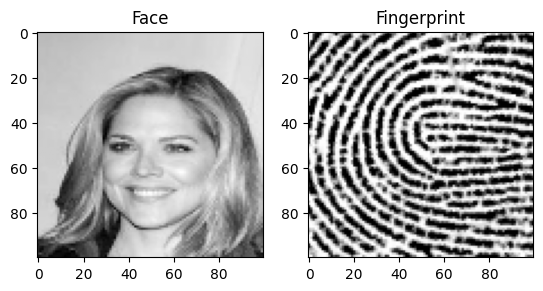

Label: 662


In [ ]:
import matplotlib.pyplot as plt

i = 0
plt.subplot(1, 2, 1)
plt.title("Face")
plt.imshow(X_face_train[i].squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Fingerprint")
plt.imshow(X_finger_train[i].squeeze(), cmap='gray')

plt.show()
print("Label:", np.argmax(y_train[i]))


In [ ]:
loss, accuracy = model.evaluate([X_face_test, X_finger_test], y_test)
print("✅ Test Accuracy:", accuracy)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.0000e+00 - loss: 9.5093
✅ Test Accuracy: 0.0
